## Set Up

In [ ]:
# Checking out the GPU we have access to. This is output is from the google colab version. 
!nvidia-smi

Sun Jan  8 06:47:26 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   64C    P0    31W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
! pwd

/content


In [ ]:
# Install transformers and PyTorch Lightning libraries

!pip install datasets transformers
!pip install pytorch-lightning
!pip install SentencePiece

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import json
import os, glob
import math

In [ ]:
from io import open
import unicodedata
import string
import re
import random

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
import pytorch_lightning as pl

from transformers import T5ForConditionalGeneration, AutoTokenizer
from transformers import get_linear_schedule_with_warmup, AdamW
from datasets import Dataset
import datasets

from sklearn.model_selection import train_test_split

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
#set seed

def set_seeds(seed):
    """Set seeds for reproducibility."""
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    pl.seed_everything(seed) # multi-GPU

In [ ]:
SEED = 42
# Set seeds for reproducibility
set_seeds(seed=SEED)

INFO:lightning_lite.utilities.seed:Global seed set to 42


## Load Data

In [ ]:
dataset = []
target = []
count = 0

In [ ]:
for filename in glob.glob(os.path.join(path, '*.json')):
    while count < 2:
        with open(filename, 'r') as f:
            lines = f.readlines()
        f.close()
  
        for line in lines:
            dataset.append(json.loads(line)['text'])
            target.append(json.loads(line)['title'])
        count +=1

In [ ]:
#creating the dataframe
d = {'text': dataset, 'summary': target}
df = pd.DataFrame(d)

In [ ]:
#save data as pickle file
df.to_pickle("./extracted_data.pkl")

In [ ]:
#load data
df = pd.read_pickle("./extracted_data.pkl")

In [ ]:
df.shape

(183412, 2)

In [ ]:
#taking a subset of data
df = df[:30000]

In [ ]:
df.head()

,text,summary
0,New Delhi (Sputnik): The death toll from the c...,India Confirms Second Case of Coronavirus as A...
1,Coronavirus case is confirmed in Massachusetts...,Coronavirus case is confirmed in Massachusetts...
2,Add Comment Edit\nI've decided to continue doi...,Recap of January 2020
3,24.6MB Collage: China Battles the Coronavirus ...,Collage: China Battles the Coronavirus
4,If the hit to their economies from the coronav...,EU states look in poor health to withstand a g...


In [ ]:
#checking for any null values
df.isnull().sum()

text       0
summary    0
dtype: int64

In [ ]:
# Hugging face datasets
covid19_news_dataset = Dataset.from_pandas(df)
covid19_news_dataset

Dataset({
    features: ['text', 'summary'],
    num_rows: 30000
})

Now that we have a training corpus, one final thing to check is the distribution of words in the reviews and their titles. This is especially important for summarization tasks, where short reference summaries in the data can bias the model to only output one or two words in the generated summaries. The plots below show the word distributions, and we can see that thethere are few summaries with just 0-2 words:

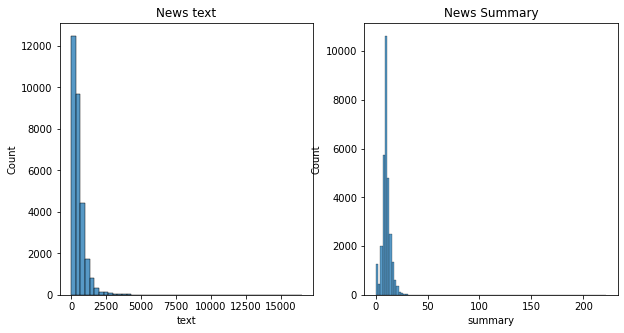

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
text_word_count = []
summary_word_count = []

# populate the lists with sentence lengths
for text in covid19_news_dataset['text']:
      text_word_count.append(len(text.split()))

for summary in covid19_news_dataset['summary']:
      summary_word_count.append(len(summary.split()))

length_df = pd.DataFrame({'text':text_word_count, 'summary':summary_word_count})


fig, axs = plt.subplots(1, 2, figsize=(10, 5))

sns.histplot(data=length_df, x="text",bins = 50,ax= axs[0])
sns.histplot(data=length_df, x="summary",bins = 100,ax= axs[1])
axs[0].set_title('News text')
axs[1].set_title('News Summary')


plt.show()

To deal with this, we’ll filter out the examples with very short titles so that our model can produce more interesting summaries.

In [ ]:
covid19_news_dataset = covid19_news_dataset.filter(lambda x: len(x["summary"].split()) > 2)

  0%|          | 0/30 [00:00<?, ?ba/s]

In [ ]:
#convert to pandas to apply preprocessing
covid19_news_dataset_df = Dataset.to_pandas(covid19_news_dataset)

## Preprocess data

In [ ]:
contraction_mapping = {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", "couldn't": "could not",

                           "didn't": "did not", "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not",

                           "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is",

                           "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would",

                           "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would",

                           "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam",

                           "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have", "must've": "must have",

                           "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock",

                           "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have",

                           "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is",

                           "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have","so's": "so as",

                           "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would",

                           "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have",

                           "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have",

                           "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are",

                           "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are",

                           "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is",

                           "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have",

                           "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have",

                           "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all",

                           "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have",

                           "you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have",

                           "you're": "you are", "you've": "you have"}

In [ ]:
def preprocess(text):
    text = text.lower() # lowercase
    text = text.split() # split the text into list on whitespace

    #applying contradiction mapping
    for i in range(len(text)):
        word = text[i]
        if word in contraction_mapping:
            text[i] = contraction_mapping[word]
    text = " ".join(text)

    text = text.replace("'s",'') # convert your's -> your
    # Remove words in parenthesis
    text = re.sub(r"\([^)]*\)", "", text)

    # Spacing and filters
    text = re.sub(r"([-;;.,!?<=>])", r" \1 ", text)
    text = re.sub("[^A-Za-z0-9]+", " ", text) # remove non alphanumeric chars
    text = re.sub(" +", " ", text)  # remove multiple spaces
    text = text.strip() #removes leading and trailing spaces
    return text

In [ ]:
# Apply to dataframe
preprocessed_df = covid19_news_dataset_df.copy()
preprocessed_df.text = preprocessed_df.text.apply(preprocess)
preprocessed_df.summary = preprocessed_df.summary.apply(preprocess)

print (f"{covid19_news_dataset_df.text.values[1]}\n\n{preprocessed_df.text.values[1]}\n")
print (f"{covid19_news_dataset_df.summary.values[1]}\n\n{preprocessed_df.summary.values[1]}")

Coronavirus case is confirmed in Massachusetts as U.S. health officials declare public health emergency By Copyright © 2020 CBS Interactive Inc. All rights reserved.
View CBS News In We're everywhere you need us to be. #YourNewsLeader Talk to Us Talk to WCBI’s anchors, reporters and meteorologists. When you see news happening, share it! We’d love to hear from you. Closed Captioning Watch Us We live, work and play right here in North Mississippi. We are your neighbors. We celebrate community and we tell your stories. We are the most trusted source for local news. Live Stream Get Alerts Download the WCBI News App on your smart phone or tablet device to receive breaking news and weather push notifications the minute it happens.

coronavirus case is confirmed in massachusetts as u s health officials declare public health emergency by copyright 2020 cbs interactive inc all rights reserved view cbs news in we are everywhere you need us to be yournewsleader talk to us talk to wcbi s anchors r

In [ ]:
covid19_news_dataset = Dataset.from_pandas(preprocessed_df)

## Split Data

In [ ]:
# 70% train, 30% test + validation
train_test_dataset = covid19_news_dataset.train_test_split(test_size=0.3,seed = 42)
# Split the 30% test + valid in half test, half valid
test_valid = train_test_dataset['test'].train_test_split(test_size=0.5,seed = 42)
# gather everyone if you want to have a single DatasetDict
train_test_valid_dataset = datasets.DatasetDict({
    'train': train_test_dataset['train'],
    'test': test_valid['test'],
    'valid': test_valid['train']})

In [ ]:
covid19_news_dataset = train_test_valid_dataset

In [ ]:
covid19_news_dataset

DatasetDict({
    train: Dataset({
        features: ['text', 'summary'],
        num_rows: 20118
    })
    test: Dataset({
        features: ['text', 'summary'],
        num_rows: 4311
    })
    valid: Dataset({
        features: ['text', 'summary'],
        num_rows: 4311
    })
})

In [ ]:
def show_samples(dataset, num_samples=5, seed=42):
    sample = dataset["train"].shuffle(seed=seed).select(range(num_samples))
    for example in sample:
        print(f"\n'>> Title: {example['summary']}'")
        print(f"'>> Review: {example['text']}'")


show_samples(covid19_news_dataset)


'>> Title: china coronavirus death toll surges every moments'
'>> Review: an elderly man collapsed and died in the street in wuhan on thursday hector retamal afp japan to enforce special measures nhk bd rescued 316 from china special correspondent bangladesh has evacuated 316 of its citizens including 15 children from the chinese city of wuhan in a chartered plane of biman bangladesh airlines the carrier s chief executive mokabbir hossain told seven of the returnees were transported to hospital shortly after their arrival in dhaka an airport health official said adding that the rest of the evacuees will be placed in quarantine for two weeks at ashkona hajj camp near the airport a nurse among the returnee has shifted to combined military hospital the china officially has confirmed 259 deaths but the actual death cases are more than 1000 the sources said yesterday as foreign nations tightened restrictions on travellers from china in response to the rapid spread of the illness most of th

## Evaluation Metric: ROUGE

In [ ]:
!pip install rouge_score

In [ ]:
! pip install evaluate

In [ ]:
rouge = datasets.load_metric('rouge')

<ipython-input-42-2a60efcbf91c>:1: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  rouge = datasets.load_metric('rouge')


## Baseline Model

In [ ]:
!pip install nltk

In [ ]:
import nltk

nltk.download("punkt")

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [ ]:
from nltk.tokenize import sent_tokenize


def three_sentence_summary(text):
    return "\n".join(sent_tokenize(text)[:3])


print(three_sentence_summary(covid19_news_dataset["train"][1]["text"]))

hong kong economy shrinks for first time in a decade by afp hong kong confirmed monday it plunged into recession in 2019 suffering its first annual contraction in a decade as the city buckled under the twin pressures of the us china trade war and months of furious pro democracy protests the data was released as the semi autonomous city begins the lunar new year facing another economic crisis the outbreak of a deadly new coronavirus strain which began on the chinese mainland and is compounding hong kong s economic woes last year was the worst for hong kong s growth since 2009 when the financial hub was hit hard by the global financial crash the crisis was initially sparked by the trade war between beijing and washington hitting the export heavy economy but the hard times were made worse by months of seething and often violent protests seeking greater democracy and police accountability official figures released on monday showed hong kong s gross domestic product shrank 1 2 percent on ye

In [ ]:
def evaluate_baseline(dataset, metric):
    summaries = [three_sentence_summary(text) for text in dataset["text"]]
    return metric.compute(predictions=summaries, references=dataset["summary"])

In [ ]:
import pandas as pd

score = evaluate_baseline(covid19_news_dataset["valid"], rouge)
rouge_names = ["rouge1", "rouge2", "rougeL", "rougeLsum"]
rouge_dict = dict((rn, round(score[rn].mid.fmeasure * 100, 2)) for rn in rouge_names)
rouge_dict

{'rouge1': 6.06, 'rouge2': 3.37, 'rougeL': 5.41, 'rougeLsum': 5.41}

## Tokenizer and Model (T5-Small)

In [ ]:
from transformers import AutoTokenizer

model_checkpoint = 't5-small'
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)

Downloading:   0%|          | 0.00/1.21k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/792k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.39M [00:00<?, ?B/s]

/usr/local/lib/python3.8/dist-packages/transformers/models/t5/tokenization_t5_fast.py:155: FutureWarning: This tokenizer was incorrectly instantiated with a model max length of 512 which will be corrected in Transformers v5.
For now, this behavior is kept to avoid breaking backwards compatibility when padding/encoding with `truncation is True`.
- Be aware that you SHOULD NOT rely on t5-small automatically truncating your input to 512 when padding/encoding.
- If you want to encode/pad to sequences longer than 512 you can either instantiate this tokenizer with `model_max_length` or pass `max_length` when encoding/padding.
- To avoid this warning, please instantiate this tokenizer with `model_max_length` set to your preferred value.
  warnings.warn(


In [ ]:
inputs = tokenizer("I loved reading the Hunger Games!")
inputs

{'input_ids': [27, 1858, 1183, 8, 26049, 5880, 55, 1], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1]}

In [ ]:
tokenizer.convert_ids_to_tokens(inputs.input_ids)

['▁I', '▁loved', '▁reading', '▁the', '▁Hunger', '▁Games', '!', '</s>']

In [ ]:
max_input_length = 512
max_target_length = 30


def preprocess_function(examples):
    model_inputs = tokenizer(
        examples["text"],
        max_length=max_input_length,
        truncation=True,
    )
    labels = tokenizer(
        examples["summary"], max_length=max_target_length, truncation=True
    )
    model_inputs["labels"] = labels["input_ids"]
    return model_inputs

In [ ]:
tokenized_datasets = covid19_news_dataset.map(preprocess_function, batched=True)

  0%|          | 0/21 [00:00<?, ?ba/s]

  0%|          | 0/5 [00:00<?, ?ba/s]

  0%|          | 0/5 [00:00<?, ?ba/s]

In [ ]:
tokenized_datasets

DatasetDict({
    train: Dataset({
        features: ['text', 'summary', 'input_ids', 'attention_mask', 'labels'],
        num_rows: 20118
    })
    test: Dataset({
        features: ['text', 'summary', 'input_ids', 'attention_mask', 'labels'],
        num_rows: 4311
    })
    valid: Dataset({
        features: ['text', 'summary', 'input_ids', 'attention_mask', 'labels'],
        num_rows: 4311
    })
})

In [ ]:
!pip install nltk

In [ ]:
import nltk

nltk.download("punkt")

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [ ]:
from nltk.tokenize import sent_tokenize


def three_sentence_summary(text):
    return "\n".join(sent_tokenize(text)[:3])


print(three_sentence_summary(covid19_news_dataset["train"][1]["text"]))

hong kong economy shrinks for first time in a decade by afp hong kong confirmed monday it plunged into recession in 2019 suffering its first annual contraction in a decade as the city buckled under the twin pressures of the us china trade war and months of furious pro democracy protests the data was released as the semi autonomous city begins the lunar new year facing another economic crisis the outbreak of a deadly new coronavirus strain which began on the chinese mainland and is compounding hong kong s economic woes last year was the worst for hong kong s growth since 2009 when the financial hub was hit hard by the global financial crash the crisis was initially sparked by the trade war between beijing and washington hitting the export heavy economy but the hard times were made worse by months of seething and often violent protests seeking greater democracy and police accountability official figures released on monday showed hong kong s gross domestic product shrank 1 2 percent on ye

In [ ]:
def evaluate_baseline(dataset, metric):
    summaries = [three_sentence_summary(text) for text in dataset["text"]]
    return metric.compute(predictions=summaries, references=dataset["summary"])

In [ ]:
import pandas as pd

score = evaluate_baseline(covid19_news_dataset["valid"], rouge)
rouge_names = ["rouge1", "rouge2", "rougeL", "rougeLsum"]
rouge_dict = dict((rn, round(score[rn].mid.fmeasure * 100, 2)) for rn in rouge_names)
rouge_dict

{'rouge1': 6.06, 'rouge2': 3.37, 'rougeL': 5.41, 'rougeLsum': 5.41}

In [ ]:
from transformers import AutoModelForSeq2SeqLM

model = AutoModelForSeq2SeqLM.from_pretrained(model_checkpoint)

In [ ]:
from transformers import Seq2SeqTrainingArguments

batch_size = 8
num_train_epochs = 5
# Show the training loss with every epoch
logging_steps = len(tokenized_datasets["train"]) // batch_size
model_name = model_checkpoint.split("/")[-1]

args = Seq2SeqTrainingArguments(
    output_dir=f"{model_name}-finetuned",
    evaluation_strategy="epoch",
    save_strategy="epoch",
    save_total_limit=4,
    learning_rate=5.6e-5,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    weight_decay=0.01,
    warmup_steps=500,
    num_train_epochs=num_train_epochs,
    predict_with_generate=True,
    logging_steps=logging_steps,
    load_best_model_at_end=True
)

In [ ]:
import numpy as np

def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    # Decode generated summaries into text
    decoded_preds = tokenizer.batch_decode(predictions, skip_special_tokens=True)
    # Replace -100 in the labels as we can't decode them
    labels = np.where(labels != -100, labels, tokenizer.pad_token_id)
    # Decode reference summaries into text
    decoded_labels = tokenizer.batch_decode(labels, skip_special_tokens=True)
    # ROUGE expects a newline after each sentence
    decoded_preds = ["\n".join(sent_tokenize(pred.strip())) for pred in decoded_preds]
    decoded_labels = ["\n".join(sent_tokenize(label.strip())) for label in decoded_labels]
    # Compute ROUGE scores
    result = rouge.compute(
        predictions=decoded_preds, references=decoded_labels, use_stemmer=True
    )
    # Extract the median scores
    result = {key: value.mid.fmeasure * 100 for key, value in result.items()}
    return {k: round(v, 4) for k, v in result.items()}

In [ ]:
from transformers import DataCollatorForSeq2Seq

data_collator = DataCollatorForSeq2Seq(tokenizer, model=model)

In [ ]:
tokenized_datasets

DatasetDict({
    train: Dataset({
        features: ['text', 'summary', 'input_ids', 'attention_mask', 'labels'],
        num_rows: 20118
    })
    test: Dataset({
        features: ['text', 'summary', 'input_ids', 'attention_mask', 'labels'],
        num_rows: 4311
    })
    valid: Dataset({
        features: ['text', 'summary', 'input_ids', 'attention_mask', 'labels'],
        num_rows: 4311
    })
})

In [ ]:
features = [tokenized_datasets["train"][i] for i in range(2)]

In [ ]:
from transformers import Seq2SeqTrainer,EarlyStoppingCallback

trainer = Seq2SeqTrainer(
    model,
    args,
    train_dataset=tokenized_datasets["train"],
    eval_dataset=tokenized_datasets["valid"],
    data_collator=data_collator,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
    callbacks = [EarlyStoppingCallback(early_stopping_patience = 3)]
)

In [ ]:
trainer.train()

The following columns in the training set don't have a corresponding argument in `T5ForConditionalGeneration.forward` and have been ignored: text, summary. If text, summary are not expected by `T5ForConditionalGeneration.forward`,  you can safely ignore this message.
/usr/local/lib/python3.8/dist-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 20118
  Num Epochs = 5
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 12575
  Number of trainable parameters = 60506624


Epoch,Training Loss,Validation Loss,Rouge1,Rouge2,Rougel,Rougelsum
1,2.249400,1.836025,45.744200,32.153300,43.256300,43.184000


The following columns in the evaluation set don't have a corresponding argument in `T5ForConditionalGeneration.forward` and have been ignored: text, summary. If text, summary are not expected by `T5ForConditionalGeneration.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 4311
  Batch size = 8
Saving model checkpoint to t5-small-finetuned/checkpoint-2515
Configuration saved in t5-small-finetuned/checkpoint-2515/config.json
Model weights saved in t5-small-finetuned/checkpoint-2515/pytorch_model.bin
tokenizer config file saved in t5-small-finetuned/checkpoint-2515/tokenizer_config.json
Special tokens file saved in t5-small-finetuned/checkpoint-2515/special_tokens_map.json
Copy vocab file to t5-small-finetuned/checkpoint-2515/spiece.model


Epoch,Training Loss,Validation Loss,Rouge1,Rouge2,Rougel,Rougelsum
1,2.249400,1.836025,45.744200,32.153300,43.256300,43.184000
2,1.906500,1.733058,48.385700,34.611600,45.872700,45.833000
3,1.795600,1.680146,49.113000,35.850400,46.619100,46.563000
4,1.731700,1.657861,49.806500,36.431600,47.290700,47.220500
5,1.696800,1.646517,50.130900,36.866800,47.708100,47.622800


The following columns in the evaluation set don't have a corresponding argument in `T5ForConditionalGeneration.forward` and have been ignored: text, summary. If text, summary are not expected by `T5ForConditionalGeneration.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 4311
  Batch size = 8
Saving model checkpoint to t5-small-finetuned/checkpoint-5030
Configuration saved in t5-small-finetuned/checkpoint-5030/config.json
Model weights saved in t5-small-finetuned/checkpoint-5030/pytorch_model.bin
tokenizer config file saved in t5-small-finetuned/checkpoint-5030/tokenizer_config.json
Special tokens file saved in t5-small-finetuned/checkpoint-5030/special_tokens_map.json
Copy vocab file to t5-small-finetuned/checkpoint-5030/spiece.model
The following columns in the evaluation set don't have a corresponding argument in `T5ForConditionalGeneration.forward` and have been ignored: text, summary. If text, summary are not expected by `T5ForConditio

TrainOutput(global_step=12575, training_loss=1.8759991907836429, metrics={'train_runtime': 4656.3009, 'train_samples_per_second': 21.603, 'train_steps_per_second': 2.701, 'total_flos': 1.3612416167313408e+16, 'train_loss': 1.8759991907836429, 'epoch': 5.0})

In [ ]:
trainer.evaluate()

The following columns in the evaluation set don't have a corresponding argument in `T5ForConditionalGeneration.forward` and have been ignored: text, summary. If text, summary are not expected by `T5ForConditionalGeneration.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 4311
  Batch size = 8


{'eval_loss': 1.6465165615081787,
 'eval_rouge1': 50.1309,
 'eval_rouge2': 36.8668,
 'eval_rougeL': 47.7081,
 'eval_rougeLsum': 47.6228,
 'eval_runtime': 213.3026,
 'eval_samples_per_second': 20.211,
 'eval_steps_per_second': 2.527,
 'epoch': 5.0}

In [ ]:
predictions,label_ids,metrics = trainer.predict(tokenized_datasets["test"])

The following columns in the test set don't have a corresponding argument in `T5ForConditionalGeneration.forward` and have been ignored: text, summary. If text, summary are not expected by `T5ForConditionalGeneration.forward`,  you can safely ignore this message.
***** Running Prediction *****
  Num examples = 4311
  Batch size = 8


In [ ]:
predictions.shape,label_ids.shape

((4311, 20), (4311, 30))

In [ ]:
#evaluation on test set
metrics

{'test_loss': 1.6305550336837769,
 'test_rouge1': 50.0168,
 'test_rouge2': 36.8232,
 'test_rougeL': 47.6694,
 'test_rougeLsum': 47.6084,
 'test_runtime': 214.0206,
 'test_samples_per_second': 20.143,
 'test_steps_per_second': 2.518}

## Inference

In [ ]:
! pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.8/5.8 MB 92.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 88.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 182.4/182.4 KB 20.4 MB/s eta 0:00:00


In [ ]:
from transformers import pipeline

model_checkpoint = "./t5-small-finetuned/checkpoint-12575"
summarizer = pipeline("summarization", model=model_checkpoint)

In [ ]:
def print_summary(idx):
    text = covid19_news_dataset["test"][idx]["text"]
    actual_summary = covid19_news_dataset["test"][idx]["summary"]
    predicted_summary = summarizer(covid19_news_dataset["test"][idx]["text"])[0]["summary_text"]
    print(f"'>>> News: {text}'")
    print(f"\n'>>> Actual Summary: {actual_summary}'")
    print(f"\n'>>> Predicted Summary: {predicted_summary}'")

In [ ]:
print_summary(2)

Token indices sequence length is longer than the specified maximum sequence length for this model (624 > 512). Running this sequence through the model will result in indexing errors


'>>> News: china central bank said it will inject 1 2 trillion yuan worth of liquidity into the markets via reverse repo operations on monday as the country prepares to reopen its stock markets amid a new coronavirus outbreak file photo a woman walks out of the headquarters of the people bank of china the central bank in beijing november 20 2013 reuters jason lee file photo 02 feb 2020 04 40pm share this content bookmark shanghai china central bank said it will inject 1 2 trillion yuan worth of liquidity into the markets via reverse repo operations on monday as the country prepares to reopen its stock markets amid a new coronavirus outbreak china authorities have pledged to use various monetary policy tools to ensure liquidity remains reasonably ample and to support firms affected by the virus epidemic which has so far claimed 305 lives all but one in china the people bank of china made the announcement in a statement published on its website on sunday adding the total liquidity in the

## Gradio Web App

In [ ]:
! pip install gradio

In [ ]:
examples = covid19_news_dataset["test"]['text'][2]

In [ ]:
examples = 'china central bank said it will inject 1 2 trillion yuan worth of liquidity into the markets via reverse repo operations on monday as the country prepares to reopen its stock markets amid a new coronavirus outbreak file photo a woman walks out of the headquarters of the people bank of china the central bank in beijing november 20 2013 reuters jason lee file photo 02 feb 2020 04 40pm share this content bookmark shanghai china central bank said it will inject 1 2 trillion yuan worth of liquidity into the markets via reverse repo operations on monday as the country prepares to reopen its stock markets amid a new coronavirus outbreak china authorities have pledged to use various monetary policy tools to ensure liquidity remains reasonably ample and to support firms affected by the virus epidemic which has so far claimed 305 lives all but one in china the people bank of china made the announcement in a statement published on its website on sunday adding the total liquidity in the banking system will be 900 billion yuan higher than the same period in 2019 after the injection according to reuters calculations based on official central bank data 1 05 trillion yuan worth of reverse repos are set to mature on monday meaning that 150 billion yuan in net cash will be injected investors are bracing for a volatile session in chinese markets when onshore trades resume on monday after a break for the lunar new year which was extended by the government china stock currency and bond markets have all been closed since jan 23 and had been due to re open last friday there will be no further delays to the reopening the country securities market regulator said in an interview published by the state backed people daily newspaper on sunday the china securities regulatory commission said it had taken the decision after balancing various factors and believed the outbreak impact on the market would be short term to support firms affected by the epidemic the csrc said companies that had expiring stock pledge agreements could apply for extensions with securities firms and it would urge corporate bond investors to extend the maturity dates of debt the csrc is also considering launching hedging tools for the a share market to help alleviate market panic and will suspend evening sessions of futures trading starting from monday it said we believe that the successive introduction and implementation of policy measures will play a better role in improving market expectations and preventing irrational behavior it told the people daily newspaper china is facing mounting isolation as other countries introduce travel curbs airlines suspend flights and governments evacuate their citizens risking worsening a slowdown in the world second largest economy on sunday the philippines reported the growing epidemic of a coronavirus has claimed its first fatality outside of china where new confirmed infections jumped by a daily record to top 14 000 cases source reuters'

In [ ]:
import gradio as gr
title = 'Text Summarization'

def text_summarizer(text):
    summary = summarizer(text)[0]["summary_text"]
    return summary

demo = gr.Interface(fn = text_summarizer,
inputs = gr.Textbox(placeholder="Enter News here...",label = "News"),
outputs = gr.Textbox(label="Generated Summary"),
title = title,
examples=[examples],
allow_flagging = False)  


demo.launch()

In [ ]:
text_summarizer('china central bank said it will inject 1 2 trillion yuan worth of liquidity into the markets via reverse repo operations on monday as the country prepares to reopen its stock markets amid a new coronavirus outbreak file photo a woman walks out of the headquarters of the people bank of china the central bank in beijing november 20 2013 reuters jason lee file photo 02 feb 2020 04 40pm share this content bookmark shanghai china central bank said it will inject 1 2 trillion yuan worth of liquidity into the markets via reverse repo operations on monday as the country prepares to reopen its stock markets amid a new coronavirus outbreak china authorities have pledged to use various monetary policy tools to ensure liquidity remains reasonably ample and to support firms affected by the virus epidemic which has so far claimed 305 lives all but one in china the people bank of china made the announcement in a statement published on its website on sunday adding the total liquidity in the banking system will be 900 billion yuan higher than the same period in 2019 after the injection according to reuters calculations based on official central bank data 1 05 trillion yuan worth of reverse repos are set to mature on monday meaning that 150 billion yuan in net cash will be injected investors are bracing for a volatile session in chinese markets when onshore trades resume on monday after a break for the lunar new year which was extended by the government china stock currency and bond markets have all been closed since jan 23 and had been due to re open last friday there will be no further delays to the reopening the country securities market regulator said in an interview published by the state backed people daily newspaper on sunday the china securities regulatory commission said it had taken the decision after balancing various factors and believed the outbreak impact on the market would be short term to support firms affected by the epidemic the csrc said companies that had expiring stock pledge agreements could apply for extensions with securities firms and it would urge corporate bond investors to extend the maturity dates of debt the csrc is also considering launching hedging tools for the a share market to help alleviate market panic and will suspend evening sessions of futures trading starting from monday it said we believe that the successive introduction and implementation of policy measures will play a better role in improving market expectations and preventing irrational behavior it told the people daily newspaper china is facing mounting isolation as other countries introduce travel curbs airlines suspend flights and governments evacuate their citizens risking worsening a slowdown in the world second largest economy on sunday the philippines reported the growing epidemic of a coronavirus has claimed its first fatality outside of china where new confirmed infections jumped by a daily record to top 14 000 cases source reuters')

'china central bank to inject 1 2 trillion yuan worth of liquidity on monday amid new coronavirus outbreak reuters'

## Push to Hub

In [ ]:
! pip install huggingface_hub transformers

In [ ]:
from transformers import AutoTokenizer,AutoModelForSeq2SeqLM

checkpoint = "./t5-small-finetuned/checkpoint-12575"
model = AutoModelForSeq2SeqLM.from_pretrained(checkpoint)
tokenizer = AutoTokenizer.from_pretrained(checkpoint)


In [ ]:
type(model)

transformers.models.t5.modeling_t5.T5ForConditionalGeneration

In [ ]:
from huggingface_hub import notebook_login

notebook_login()

Token is valid.
Your token has been saved in your configured git credential helpers (store).
Your token has been saved to /root/.huggingface/token
Login successful


In [ ]:
model.push_to_hub("covid19_news_summarization_finetuned")

In [ ]:
tokenizer.push_to_hub("covid19_news_summarization_finetuned")